In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading dataframes for each protein into python 
Renaming columns to be easily accessable, normalizing the excitation and emission spectra, taking sum of column 

In [15]:
df_mEmerald = pd.read_csv('mEmerald_fpbase_spectra.csv')
df_mEmerald.fillna(0, inplace = True)
df_mTagBFP2 = pd.read_csv('mTagBFP2_fpbase_spectra.csv')
df_mTagBFP2.fillna(0, inplace = True)
df_mCherry = pd.read_csv('mCherry_fpbase_spectra.csv')
df_mCherry.fillna(0, inplace = True)
df_mNeptune2p5 = pd.read_csv('mNeptune2p5_fbpase_spectra.csv')
df_mNeptune2p5.fillna(0, inplace = True)

mEmerald_columns = df_mEmerald.rename(columns ={'mEmerald ex': 'excitation', 'mEmerald em': 'emission'})
mTagBFP2_columns = df_mTagBFP2.rename(columns ={'mTagBFP2 ex': 'excitation', 'mTagBFP2 em': 'emission'})
mCherry_columns = df_mCherry.rename(columns ={'mCherry ex': 'excitation', 'mCherry em': 'emission'})
mNeptune2p5_columns = df_mNeptune2p5.rename(columns ={'mNeptune2.5 ex': 'excitation', 'mNeptune2.5 em': 'emission'})

spectra_list = [mEmerald_columns, mTagBFP2_columns, mCherry_columns, mNeptune2p5_columns]
for j in range(0,4):
    excitation_column = spectra_list[j]['excitation']
    area = np.trapz(excitation_column, dx = 1)
    normalized = excitation_column/area
    excitation_column = normalized
    spectra_list[j]['excitation'] = normalized
    new_area = np.trapz(excitation_column, dx = 1)
    column = spectra_list[j]['emission']
    area_emission = np.trapz(column, dx = 1)
    normalized_em = column/area_emission
    column = normalized_em
    spectra_list[j]['emission'] = normalized_em
    new_area_em = np.trapz(column, dx = 1)

### Making sure each spectra dataframe has data for 400-900nm

In [16]:
wavelength = 701
for index in range(401, 601):
    mEmerald_columns.loc[len(mEmerald_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

wavelength = 651
for index in range(341, 591):
    mTagBFP2_columns.loc[len(mTagBFP2_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

wavelength = 851
for index in range(621, 671):
    mNeptune2p5_columns.loc[len(mNeptune2p5_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

### Function to solve emission bin area using i and j 
Corresponding lambda_min and lambda_max to the min and max wavelengths in channel i in a list of the 200 total bins 

In [17]:
spectra_list = [mEmerald_columns, mTagBFP2_columns, mCherry_columns, mNeptune2p5_columns]

def calc_emission_bin(i, j):
    bins_list = [*range(400, 900, 10)]
    total_bins = 4*bins_list 
    df_spectra = spectra_list[j]
    lambda_min = total_bins[i]
    lambda_max = lambda_min + 10
    bin_i = range(lambda_min, lambda_max)
    df_sliced_data = df_spectra.loc[df_spectra['wavelength'].isin(bin_i)]
    # print(df_sliced_data)
    sliced_data_emmision = df_sliced_data['emission']
    emission_bin = np.trapz(sliced_data_emmision)
    # print('Emission bin sum for i = ', i, 'and j = ', j, 'is', emission_bin)
    return emission_bin

### Function to calculate the excitation values from the illumination wavelengths
Figure out how to go into csv and grab the specific excitation values from the dataframe that you found earlier. Can use for loop and/or a function. 

Excitation value corresponding to excitation wavelengths for each protein: 405nm, 488nm, 561nm, 637nm. Found these values on csv files

In [18]:
mEmerald_excitation = [0.1732, 0.9982, 0.0043, 0.0027]
mTag_excitation = [0.9588, 0, 0, 0]
mCherry_excitation = [0.0198, 0.0762, 0.6394, 0.0067]
mNeptune_excitation = [0.0279, 0.0717, 0.5819, 0.1519]

In [19]:
def calc_excitation(i, j): 
    illumation_wavelength_list = [405, 488, 561, 637]
    if 0 <= i < 50: 
        illumation_wavelength = illumation_wavelength_list[0]
    elif 50 <= i < 100: 
        illumation_wavelength = illumation_wavelength_list[1]
    elif 100 <= i < 150:
        illumation_wavelength = illumation_wavelength_list[2]
    elif 150 <= i < 200:
        illumation_wavelength = illumation_wavelength_list[3]
    else:
        print('Invalid i value')
    df_sliced = spectra_list[j].loc[spectra_list[j]['wavelength'] == illumation_wavelength]
    excitation_wavelength = df_sliced['excitation'].iloc[0]
    return excitation_wavelength


calc_excitation(2, 3)

0.0003359525187106889

### Function to index over brightness values using a given j 
Found brightness values on slack 

In [20]:
def calc_brightness(j):
    brightness_list = [39.1, 32.38, 15.85, 22.8]
    brightness = brightness_list[j]
    # print('Brightness value for j = ', j, 'is', brightness)
    return brightness

### Function for the variable $k_i$
We are trying to give each fluorophore a fair chance. Each of our illumination wavelengths is targetted mainly at a specific fluorophore. Experimentally, we can choose the illumination strengths. So, we want to balance out our illumination strengths so that a similar amount of information (photons) is collected from each fluorophore emissions.

Depends on the channel--each set of 50 channels will have a different $k_i$. Could make it depend on the brightnesses.

In [21]:
def calc_a_constant_k(i, j):
    k = 1
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a

calc_a_constant_k(15, 2)

1.4280318240240864e-06

### For loop for matrix A

In [22]:
def form_A(k_dependence=True):
    A = np.zeros((200, 4)) # 200 rows (horizontal), 4 columns (vertical)
    for j in range(0, 4):
        for i in range(0, 200):
            if k_dependence:
                A[i, j] = calc_a(i, j)
            else:
                A[i, j] = calc_a_constant_k(i, j)
    return A

In [59]:
A_constant_k = form_A(k_dependence=False)

illumination_one = A_constant_k[0:50, 0:4]
illumination_two = A_constant_k[50:100, 0:4]
illumination_three = A_constant_k[100:150, 0:4]
illumination_four = A_constant_k[150:200, 0:4]

In [97]:
def calc_k_strength(i, j, desired_photons):
        i = 50
        desired_photons = 1000
        if 0<= i < 50: 
                sliced_average = np.average(illumination_one)
                k = 1/(sliced_average * desired_photons)
        elif 50<= i < 100:
                sliced_average = np.average(illumination_two)
                k = 1/(sliced_average * desired_photons)
        elif 100<= i < 150:
                sliced_average = np.average(illumination_three)
                k = 1/(sliced_average * desired_photons)
        elif 150<= i < 200:
                sliced_average = np.average(illumination_four)
                k = 1/(sliced_average * desired_photons)
        return k 

# print(k)

def calc_a_from_photons_detected(i, j, desired_photons):
    k = calc_k_strength(i, j, desired_photons)
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a

calc_a_from_photons_detected(20, 0, 100)

matrix_A_list = []

for desired_photons in [100, 200, 300]:
        k = calc_k_strength(i, j, desired_photons)
        A = np.zeros((200, 4)) # 200 rows (horizontal), 4 columns (vertical)
        for j in range(0, 4):
                for i in range(0, 200):
                        A[i, j] = calc_a_from_photons_detected(i, j, desired_photons)
                        matrix_A_list.append(A[i, j]) ##Creating list from matrix A -- should this be one big list of the for-loop for all three desired photons?? 
        print(A)
                

[[0.00000000e+00 2.65100856e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.20703532e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.21724209e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.01515802e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.31100711e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.36580115e-02 0.00000000e+00 0.00000000e+00]
 [2.11812438e-05 3.13205135e-02 0.00000000e+00 0.00000000e+00]
 [1.37987752e-04 2.62555504e-02 0.00000000e+00 0.00000000e+00]
 [7.99106807e-04 2.13826893e-02 0.00000000e+00 0.00000000e+00]
 [2.98779404e-03 1.57291254e-02 0.00000000e+00 0.00000000e+00]
 [6.43079903e-03 1.09669150e-02 0.00000000e+00 0.00000000e+00]
 [6.75446330e-03 7.64739129e-03 0.00000000e+00 0.00000000e+00]
 [4.37923247e-03 5.31085381e-03 0.00000000e+00 0.00000000e+00]
 [3.17190158e-03 3.59999278e-03 0.00000000e+00 0.00000000e+00]
 [2.54476335e-03 2.39090236e-03 0.00000000e+00 0.00000000e+00]
 [1.79429495e-03 1.60558910e-03 5.14564667e-07 0.000000

### Function to solve for matrix A just inputting i and j value 
All above functions called in this function to reduce reduncancy in solving for the matrix value

In [25]:
def calc_a(i, j):
    k = calc_k(i, j)
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a

calc_a(15, 2)

0.00032611192620574407

### How to save array as csv

In [26]:
# np.savetxt("Matrix A.csv", A, delimiter=",")

Turning dataframe into csv

In [27]:
# mEmerald_columns.to_csv('mEmerald_columns 1')

### Create a vector consisting of some concentration of each fluorophore
The concentrations don't have to all be the same. Modeling our imaging system -- using one of each fluorophore in this example. Each index corresponds to a fluorophore

In [28]:
x = [1, 1, 1, 1] ##might have to switch orientation if error (transpose)

### Function to calculate FOM from A and x 
1. Multiplying Matrix A by Vector x (calculating the measurements of y using imaging model)
2. Transposing A using simple command '.T'
3. Creating diagonal matrix of 1/y
4. Multiply all three matrices and compute the fisher information matrix
5. Inversing the fisher information matrix. 
6. Take out all the diagonal elements in the fisher information matrix (these are the CRLB numbers).
7. Square root all the CRLB numbers.
8. Divide the fluorophore concentrations by the square-rooted CRLB numbers (would have to change code if don't use 1 for each concentration)

If you inverse the fisher information matrix and multiply it by the initial fisher information matrix, should get a diagonal matrix of all 1's on the diagonal (and the rest of the elements should be 0. Ours are very small numbers that would round to zero).

i.e. (idk = FIM_inverse @ FIM) should result in that

In [32]:
def calc_FOM(A, x):
    y = A @ x 
    y_reshaped = np.reshape(y, (200, 1))
    transposed_A = A.T
    FIM_y = 1/y
    FIM_y[FIM_y == np.inf] = 0
    diagonal_matrix = np.diag(FIM_y)
    FIM = transposed_A @ diagonal_matrix @ A
    FIM_inverse = np.linalg.inv(FIM)
    CRLB_0 = FIM_inverse[0,0] 
    CRLB_1 = FIM_inverse[1,1]
    CRLB_2 = FIM_inverse[2,2]
    CRLB_3 = FIM_inverse[3,3]
    CRLB_list = [CRLB_0, CRLB_1, CRLB_2, CRLB_3]
    sqrt_CRLB_list = np.sqrt(CRLB_list)
    FOM_list = [1/i for i in sqrt_CRLB_list] #would have to change this line of code if don't use 1 for each concentration
    return FOM_list

A = form_A()
FOM_list = calc_FOM(A, x)

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_9130/254424344.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


Calculating the average number of detected photons

In [55]:
A = form_A()

avg_photons_detected_list = []
for illum_count in range(4):
    start = 50 * illum_count
    end = 50 * (illum_count + 1)
    # print(f"Start row: {start}, End row: {end}")
    A_section = A[50 * illum_count : 50 * (illum_count + 1), :]
    avg_photons_detected = np.average(A_section)
    avg_photons_detected_list.append(avg_photons_detected)

print(avg_photons_detected_list)

[0.0032529964030950215, 0.002775223240673791, 0.001325349458612716, 0.00020092469972370262]


### Plotting FOMs versus the fluorophore name using matplotlib

Text(0, 0.5, 'FOM Values')

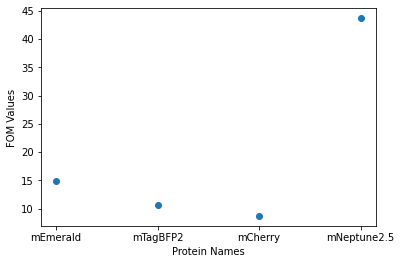

In [33]:
protein_names = ['mEmerald', 'mTagBFP2', 'mCherry', 'mNeptune2.5']
plt.scatter(protein_names, FOM_list)
plt.xlabel('Protein Names')
plt.ylabel('FOM Values')

### Using bar chart

Text(0.5, 1.0, 'Plotting FOMs versus Fluorphore Names')

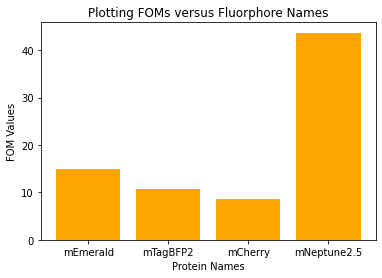

In [35]:
axis = [1, 2, 3, 4]
plt.bar(axis, FOM_list, tick_label = protein_names, width = 0.8, color = 'orange')
plt.xlabel('Protein Names')
plt.ylabel('FOM Values')
plt.title('Plotting FOMs versus Fluorphore Names')

### Plotting the FOMs against avg # of detected photons for desired_photons = 100, 200, 300
Using $x_j$ = [1, 1, 1, 1]

In [101]:
def calc_a_for_plots(i, j, desired_photons) :
    k = calc_k_strength(i, j, desired_photons)
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a_for_plot = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a_for_plot

print(a_for_plot)

In [119]:
A_for_plot = np.zeros((200, 4)) # 200 rows (horizontal), 4 columns (vertical)
for j in range(0, 4):
    for i in range(0, 200):
        A_for_plot[i, j] = calc_a_for_plots(i, j, 100)
    
    
# return A_for_plot -- it wouldn't let me put return statement


In [123]:
def calc_FOM_for_plot(A_for_plot, x):
    y = A_for_plot @ x 
    y_reshaped = np.reshape(y, (200, 1))
    transposed_A_for_plot = A_for_plot.T
    FIM_y = 1/y
    FIM_y[FIM_y == np.inf] = 0
    diagonal_matrix = np.diag(FIM_y)
    FIM = transposed_A_for_plot @ diagonal_matrix @ A_for_plot
    FIM_inverse = np.linalg.inv(FIM)
    CRLB_0 = FIM_inverse[0,0] 
    CRLB_1 = FIM_inverse[1,1]
    CRLB_2 = FIM_inverse[2,2]
    CRLB_3 = FIM_inverse[3,3]
    CRLB_list = [CRLB_0, CRLB_1, CRLB_2, CRLB_3]
    sqrt_CRLB_list = np.sqrt(CRLB_list)
    FOM_list = [1/i for i in sqrt_CRLB_list] #would have to change this line of code if don't use 1 for each concentration
    return FOM_list

x = [1, 1, 1, 1]
FOM_list_for_plot = calc_FOM_for_plot(A_for_plot, x)

print(FOM_list_for_plot)

[0.44373360582936766, 0.42077086915758377, 0.12153968704562652, 0.17202323865744004]


/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_9130/1643198702.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


In [124]:
# A = form_A()

avg_photons_detected_list = []
for illum_count in range(4):
    start = 50 * illum_count
    end = 50 * (illum_count + 1)
    # print(f"Start row: {start}, End row: {end}")
    A_section_for_plot = A_for_plot[50 * illum_count : 50 * (illum_count + 1), :]
    avg_photons_detected = np.average(A_section_for_plot)
    avg_photons_detected_list.append(avg_photons_detected)

print(avg_photons_detected_list)

[0.0011721566594784037, 0.0009999999999999998, 0.0004775649897955368, 7.23994728708457e-05]


Text(0.5, 1.0, 'Plotting FOMs versus Avg Photons Detected for 100 Desired Photons')

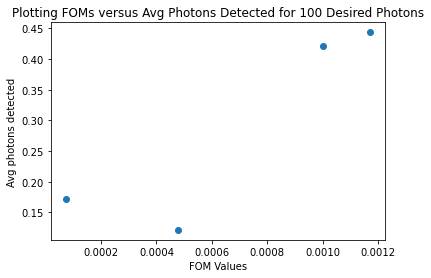

In [128]:
protein_names = ['mEmerald', 'mTagBFP2', 'mCherry', 'mNeptune2.5']
plt.scatter(avg_photons_detected_list, FOM_list_for_plot)
plt.xlabel('FOM Values')
plt.ylabel('Avg photons detected')
plt.title('Plotting FOMs versus Avg Photons Detected for 100 Desired Photons')

I don't know how I would plot all three of the desired photon values at the same time, do I need to make multiple blocks of what I have above to get all twelve values (FOMs, Avg photons detected) as variables to put on plot? Is there a way to reduce redundancy? 